# Valutazione di un modello non supervisionato: k-means clustering

In questa esercitazione si implementa un modello non supervisionato di clustering per discutere le metodologie di valutazione delle sue performance.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Patch
from matplotlib import cm
%matplotlib inline

## Definizione di una funzione di valutazione del clustering

Basata su Silhouette Score e Davies-Bouldin index.



In [2]:
def evaluate_clustering(X, labels, n_clusters, ax=None, title_suffix=''):
    """
    Evaluate a clustering model using silhouette scores and the Davies-Bouldin index.

    Parameters:
    X (ndarray): Feature matrix.
    labels (array-like): Cluster labels assigned to each sample.
    n_clusters (int): The number of clusters in the model.
    ax: The subplot axes to plot on.
    title_suffix (str): Optional suffix for plot titlec

    Returns:
    None: Displays silhoutte scores and a silhouette plot.
    """
    if ax is None:
        ax = plt.gca()  # Get the current axis if none is provided

    # Calculate silhouette scores
    silhouette_avg = silhouette_score(X, labels)
    sample_silhouette_values = silhouette_samples(X, labels)

    # Plot silhouette analysis on the provided axis
    unique_labels = np.unique(labels)
    colormap = cm.tab10
    color_dict = {label: colormap(float(label) / n_clusters) for label in unique_labels}
    y_lower = 10
    for i in unique_labels:
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = color_dict[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_title(f'Silhouette Score for {title_suffix} \n' +
                 f'Average Silhouette: {silhouette_avg:.2f}')
    ax.set_xlabel('Silhouette Coefficient')
    ax.set_ylabel('Cluster')
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", label='average')
    ax.set_xlim([-0.25, 1])  # Set the x-axis range to [0, 1]
    ax.legend()
    ax.set_yticks([])


## Generazione dataset toy e definizione del modello



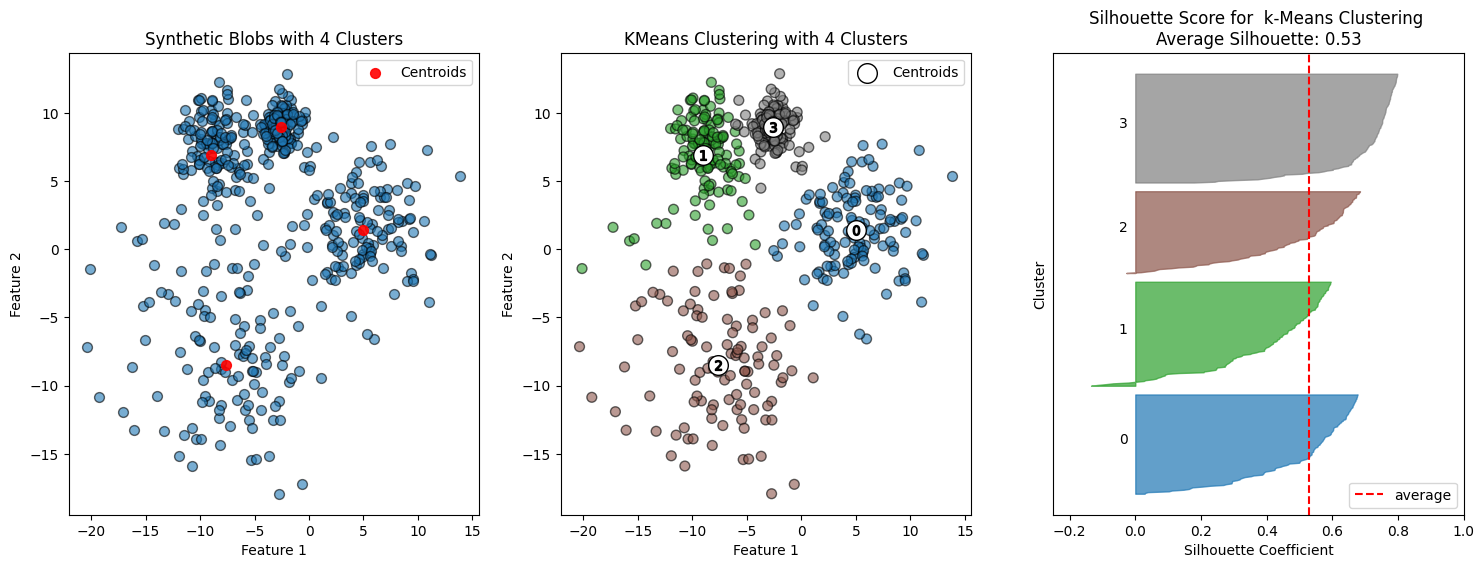

In [3]:
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=[1.0, 3, 5, 2], random_state=42)

# Modello k-means clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_kmeans = kmeans.fit_predict(X)

colormap = cm.tab10

# Plot dei dati
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], s=50, alpha=0.6, edgecolor='k')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, marker='o', alpha=0.9, label='Centroids')
plt.title(f'Synthetic Blobs with {n_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Plot the clustering result
# Create colors based on the predicted labels
colors = colormap(y_kmeans.astype(float) / n_clusters)

plt.subplot(1, 3, 2)
plt.scatter(X[:, 0], X[:, 1], c=colors, s=50, alpha=0.6, edgecolor='k')

# Label the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
    label='Centroids'
)
# Label the custer number
for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

plt.title(f'KMeans Clustering with {n_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Evaluate the clustering
plt.subplot(1, 3, 3)
evaluate_clustering(X, y_kmeans, n_clusters, title_suffix=' k-Means Clustering')
plt.show()



Un silhouette score vicino a 1 indica che il punto è molto simile a quelli nel suo cluster piuttosto che a quelli negli altri cluster; invece, un silhouette score vicino a 0 indica che il punto si trova sulla soglia di decisione tra due cluster. Questa metrica può assumere anche valori negativi, indicativi di una assegnazione errata del punto nel cluster.


## Stabilità dei cluster

Come variano i risultati se cambia il seed iniziale dei centroidi? Questo viene misurato dalla metrica inertia.



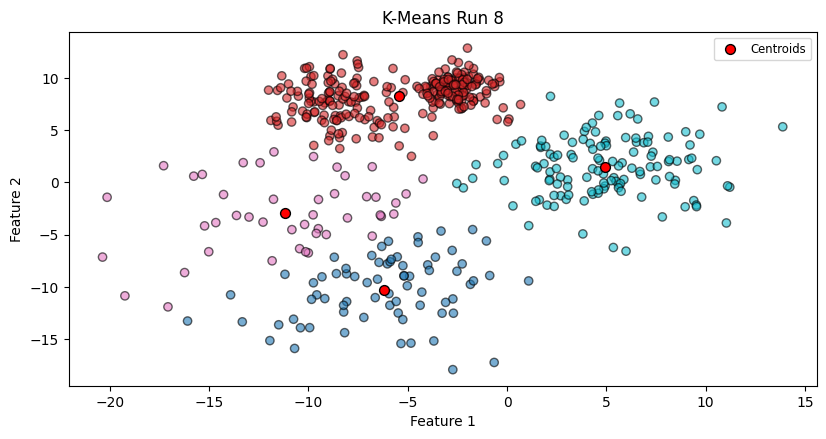

Run 1: Inertia=7633.51
Run 2: Inertia=8556.71
Run 3: Inertia=7633.51
Run 4: Inertia=7633.51
Run 5: Inertia=8556.71
Run 6: Inertia=7633.51
Run 7: Inertia=7633.51
Run 8: Inertia=8556.71


In [4]:
# Number of runs for k-means with different random states
n_runs = 8
inertia_values = []

# Calculate number of rows and columns needed for subplots
n_cols = 2  # Number of columns
n_rows = -(-n_runs // n_cols)  # Ceil division to determine rows
plt.figure(figsize=(16, 16))  # Adjust the figure size for better visualization

# Run K-Means multiple times with different random states
for i in range(n_runs):
  kmeans = KMeans(n_clusters=4, random_state=None)  # Use the default `n_init`
  kmeans.fit(X)
  inertia_values.append(kmeans.inertia_)

# Plot the clustering result
plt.subplot(n_rows, n_cols, i + 1)
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='tab10', alpha=0.6, edgecolor='k')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=50, marker='o', edgecolor='k', label='Centroids')
plt.title(f'K-Means Run {i + 1}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='upper right', fontsize='small')
plt.tight_layout()
plt.show()

# Print inertia values
for i, inertia in enumerate(inertia_values, start=1):
  print(f'Run {i}: Inertia={inertia:.2f}')

Inertia è una misura della somma delle varianze interne ai cluster; valori bassi indicano cluster compatti.

Come mostrato dai risultati del clustering, le assegnazioni dei cluster cambiano tra una esecuzione e l’altra quando si usano seeds diversi per i centroidi. Inoltre, i valori di inertia risultano incoerenti, il che indica che il processo di clustering è sensibile alla posizione iniziale dei centroidi. Questa incoerenza dell’inertia suggerisce un risultato meno affidabile.

## Stabilità del modello

Come cambiano le performance cambiando il numero dei cluster? Questo viene misurato dall'indice di Davies-Bouldin e dal Silhouette Score in funzione di k.


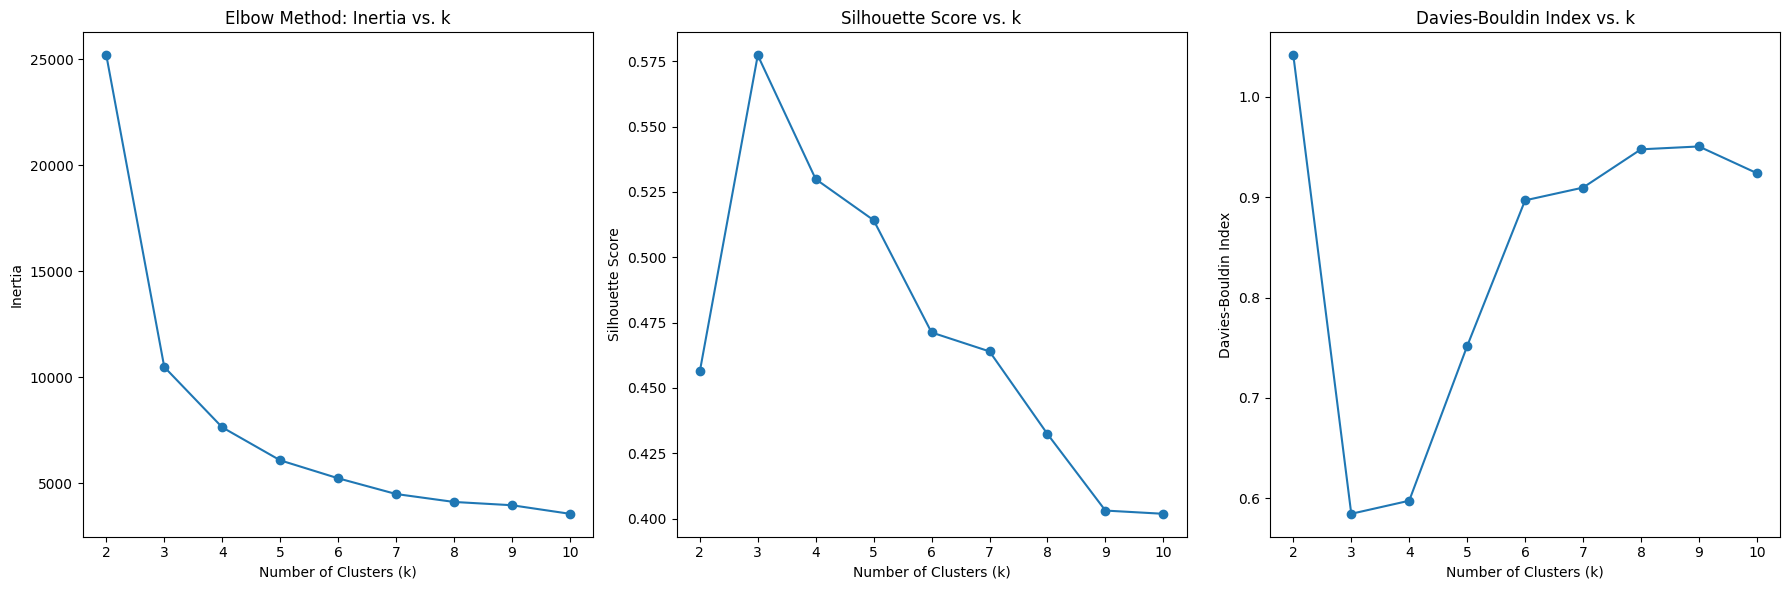

In [5]:
# Range of k values to test
k_values = range(2, 11)

# Store performance metrics
inertia_values = []
silhouette_scores = []
davies_bouldin_indices = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    y_kmeans = kmeans.fit_predict(X)

    # Calculate and store metrics
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, y_kmeans))
    davies_bouldin_indices.append(davies_bouldin_score(X, y_kmeans))

# Plot the inertia values (Elbow Method)
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method: Inertia vs. k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

# Plot silhouette scores
plt.subplot(1, 3, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

# Plot Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(k_values, davies_bouldin_indices, marker='o')
plt.title('Davies-Bouldin Index vs. k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

Il primo grafico è utile nel caso del metodo dell'elbow, ovvero si sceglie il valore ideale di k vicino al punto nel quale la curva comincia a decrescere. Tuttavia un valore di inertia troppo basso e un numero di cluster molto elevato possono indicare un rischio di overfitting, pertanto è necessario scegliere un valore che bilanci i due parametri.
Il valore ideale k = 3 è supportato anche dagli altri due grafici, tuttavia sappiamo che il numero di cluster corretto è k = 4.

Vediamo cosa succede per i valori di k = 2, 3, 4.

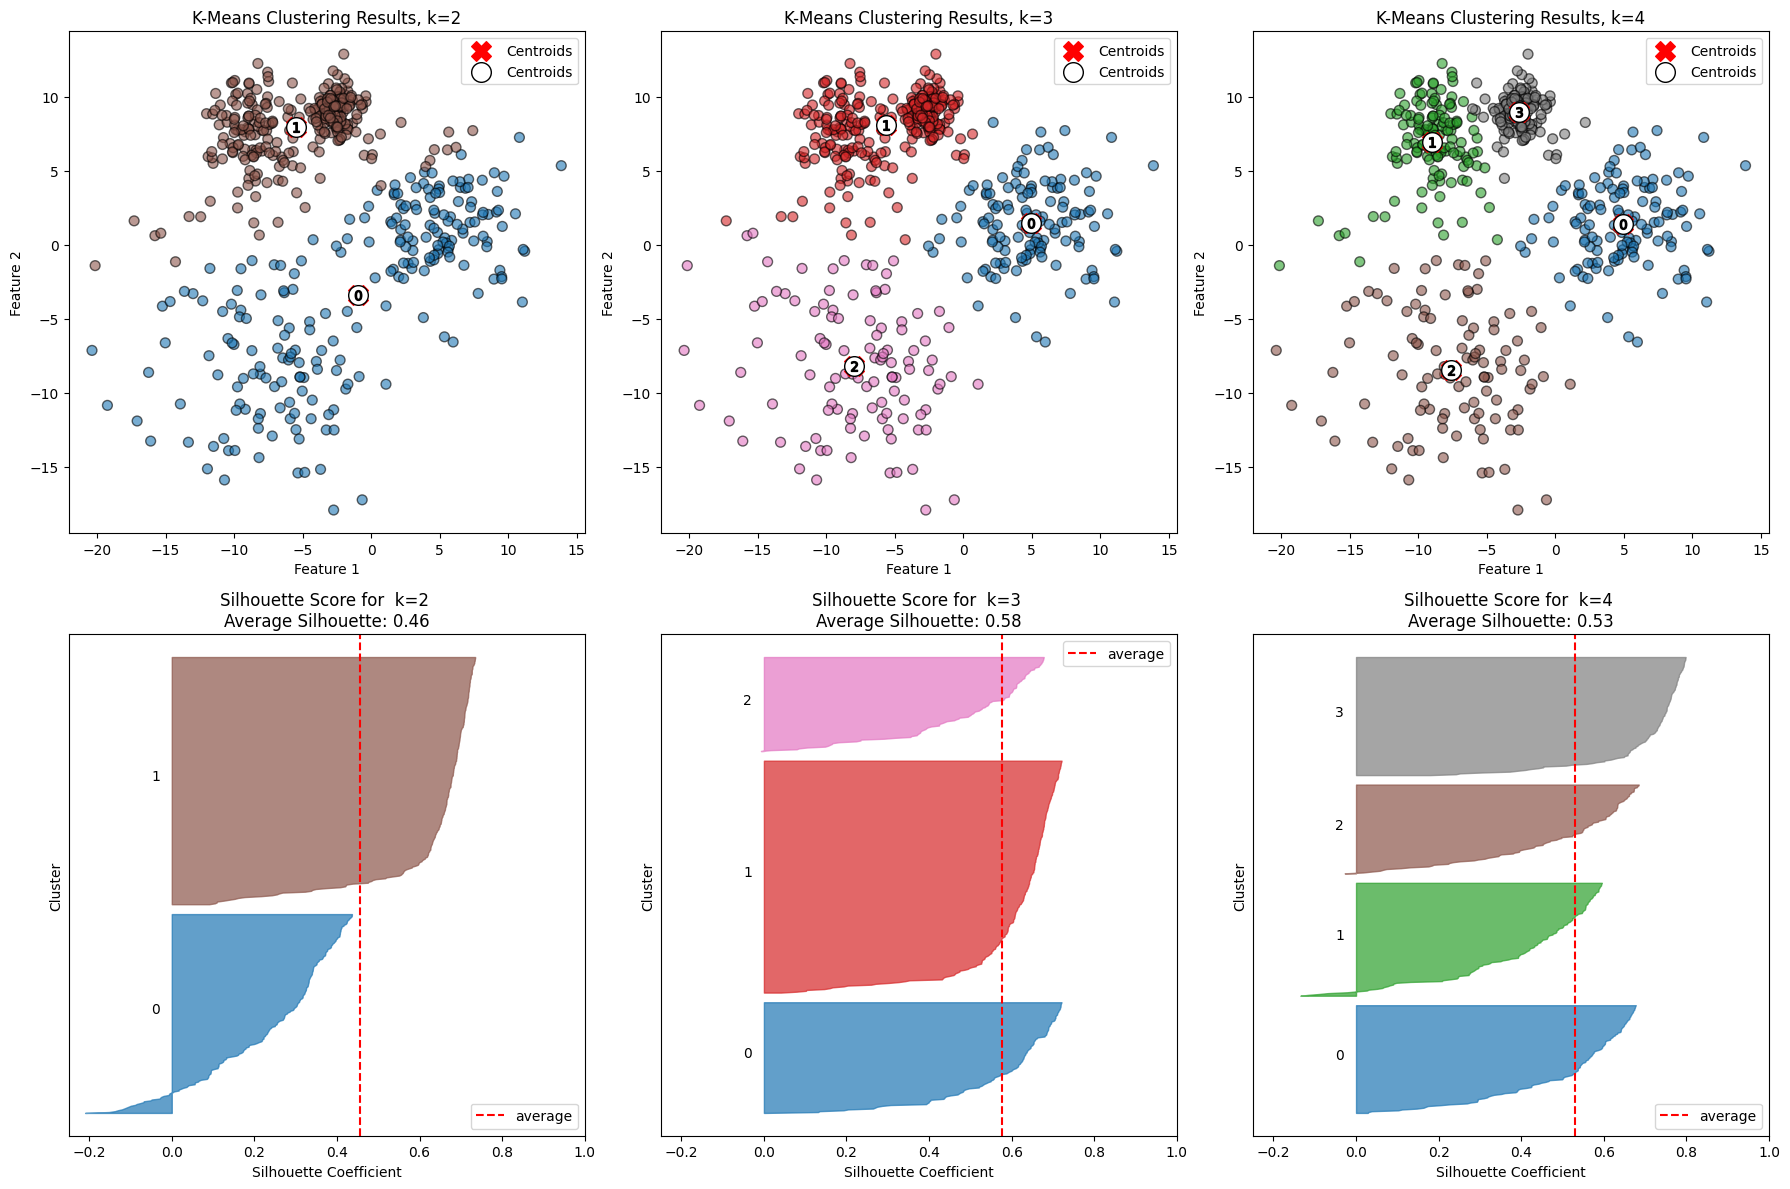

In [6]:
plt.figure(figsize=(18, 12))
colormap = cm.tab10  # Define the colormap

for i, k in enumerate([2, 3, 4]):
    # Fit KMeans and predict labels
    kmeans = KMeans(n_clusters=k, random_state=42)
    y_kmeans = kmeans.fit_predict(X)

    # Create colors based on the predicted labels
    colors = colormap(y_kmeans.astype(float) / k)

    # Scatter plot for each k in the first row (1, 2, 3)
    ax1 = plt.subplot(2, 3, i + 1)
    ax1.scatter(X[:, 0], X[:, 1], c=colors, s=50, alpha=0.6, edgecolor='k')
    ax1.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='X', label='Centroids')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    plt.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
        label='Centroids'
    )

    for i_, c in enumerate(centers):
        plt.scatter(c[0], c[1], marker="$%d$" % i_, alpha=1, s=50, edgecolor="k")

    ax1.set_title(f'K-Means Clustering Results, k={k}')
    ax1.set_xlabel('Feature 1')
    ax1.set_ylabel('Feature 2')
    ax1.legend()

    # Silhouette plot for each k in the second row (4, 5, 6)
    ax2 = plt.subplot(2, 3, i + 4)
    evaluate_clustering(X, y_kmeans, k, ax=ax2, title_suffix=f' k={k}')

plt.tight_layout()  # Adjust spacing between plots
plt.show()

Sappiamo che la scelta giusta è k=4, tuttavia anche k=3 sembra dare buoni risultati; tuttavia, con k=3 l'algoritmo non riesce a distinguere tra le due regioni vicine con densità diversa, che vengono invece distinte per k=4.

Dal plot del silhouette score nel caso di k=4 si deduce che i tre cluster hanno tutti circa la stessa densità. Tuttavia, ci sono dei punti che non sono stati classificati bene, e questo può essere dovuto al fatto che i tre cluster non appaiono del tutto separati e che possono esserci degli overlap.


## Limiti dell'algoritmo k-means

Si studia il caso in cui c'è un dataset 2D etichettato contenente tre classi distribuite con forme diverse (non blob).


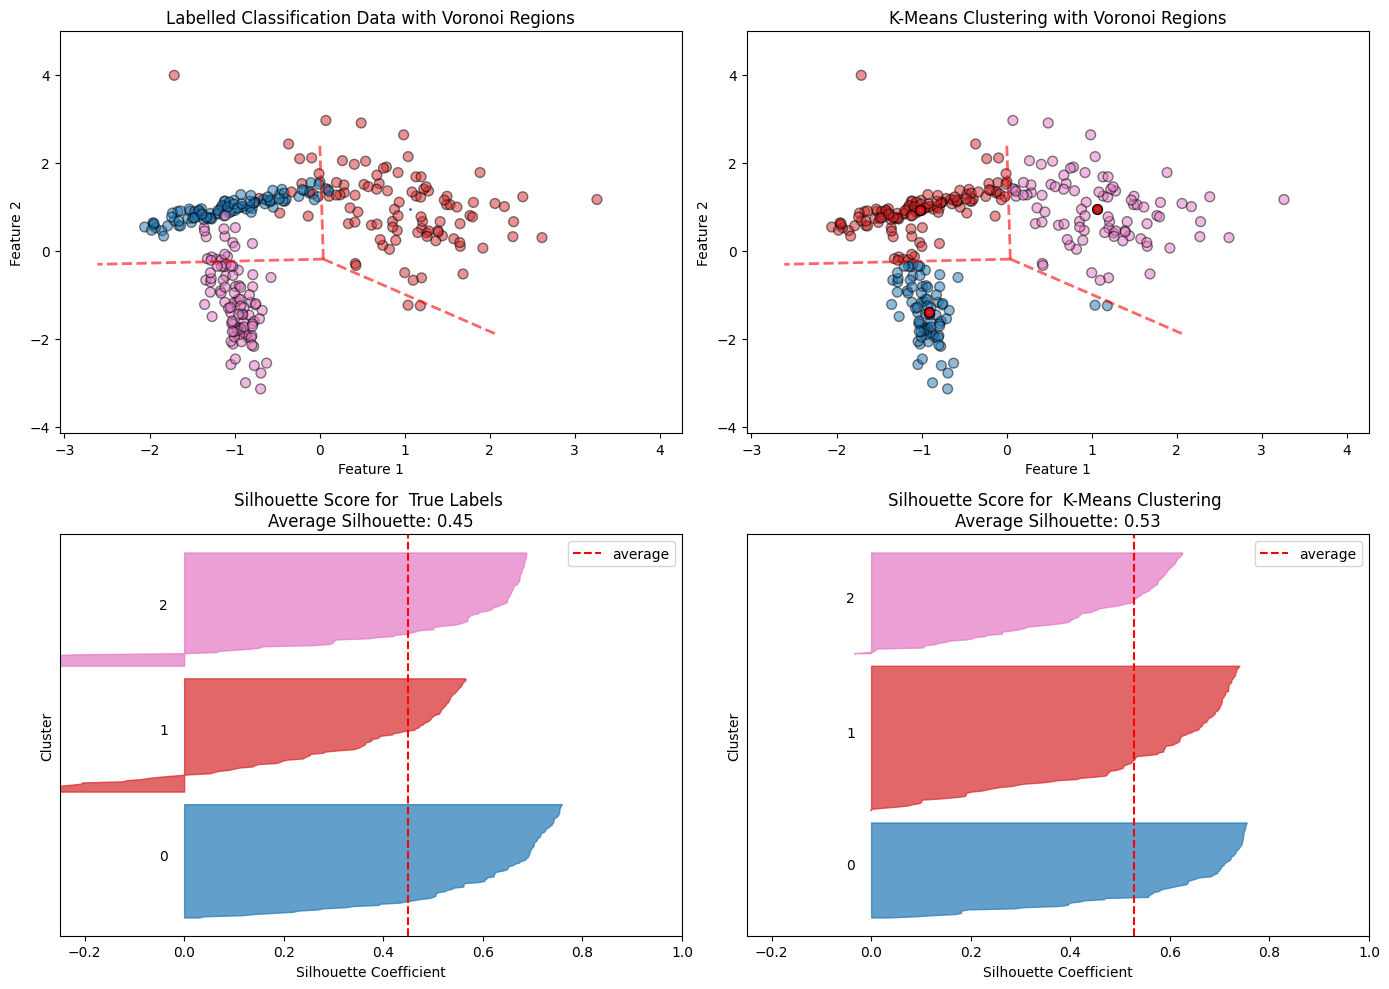

In [9]:
# Generate synthetic classification data
X, y_true = make_classification(n_samples=300, n_features=2, n_informative=2, n_redundant=0,
                                n_clusters_per_class=1, n_classes=3, random_state=42)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
y_kmeans = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

# Compute the Voronoi diagram
vor = Voronoi(centroids)

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Get consistent axis limits for all scatter plots
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# Plot the true labels with Voronoi regions
colormap = cm.tab10
colors_true = colormap(y_true.astype(float) / 3)
axes[0, 0].scatter(X[:, 0], X[:, 1], c=colors_true, s=50, alpha=0.5, ec='k')
voronoi_plot_2d(vor, ax=axes[0, 0], show_vertices=False, line_colors='red', line_width=2, line_alpha=0.6, point_size=2)
axes[0, 0].set_title('Labelled Classification Data with Voronoi Regions')
axes[0, 0].set_xlabel('Feature 1')
axes[0, 0].set_ylabel('Feature 2')
axes[0, 0].set_xlim(x_min, x_max)
axes[0, 0].set_ylim(y_min, y_max)

# Call evaluate_clustering for true labels
evaluate_clustering(X, y_true, n_clusters=3, ax=axes[1, 0], title_suffix=' True Labels')

# Plot K-Means clustering results with Voronoi regions
colors_kmeans = colormap(y_kmeans.astype(float) / 3)
axes[0, 1].scatter(X[:, 0], X[:, 1], c=colors_kmeans, s=50, alpha=0.5, ec='k')
axes[0, 1].scatter(centroids[:, 0], centroids[:, 1], c='red', s=50, marker='o', label='Centroids',  edgecolor='k')
voronoi_plot_2d(vor, ax=axes[0, 1], show_vertices=False, line_colors='red', line_width=2, line_alpha=0.6, point_size=2)

axes[0, 1].set_title('K-Means Clustering with Voronoi Regions')
axes[0, 1].set_xlabel('Feature 1')
axes[0, 1].set_ylabel('Feature 2')
axes[0, 1].set_xlim(x_min, x_max)
axes[0, 1].set_ylim(y_min, y_max)

# Call evaluate_clustering for K-Means labels
evaluate_clustering(X, y_kmeans, n_clusters=3, ax=axes[1, 1], title_suffix=' K-Means Clustering')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


L'algoritmo riesce a riconoscere tre cluster che rispecchiano le tre classi. Tuttavia, guardando in dettaglio:

- k-means non riesce a catturare la forma allungata della classe viola e celeste;
- k-means non considera la densità dei punti, ma separa i cluster in base alla distanza geometrica, e questo funziona bene solo se i cluster hanno forma sferica.

Il Silhouette Score è più alto per i cluster di K-means rispetto a quello ottenuto con le classi reali. Questo è accettabile, perché le classi reali si sovrappongono leggermente, come mostrano anche i valori negativi nel Silhouette plot.

Nei problemi reali, in genere, non si conoscono le etichette vere, quindi è bene provare diversi algoritmi per adattare l'algoritmo ai dati specifici.


